# File to process data from uni forms survey
## from importing data to processing and visualizing

In [207]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Importing data

In [208]:
# Importing data
df_uni_data = pd.read_csv('data/umfrage-nachhaltige-mobilitaet_FHDW.csv')

## Methods for data processing

In [209]:
#Constants for column names
COLUMN_NAMES = {
    'age': 'Wie alt sind Sie? ',
    'employment': 'Wie ist Ihre Beschäftigung? ',
    'monthly_income': 'Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)',
    'car_ownership': 'Besitzen Sie ein Auto? (auch Leasing) ',
    'interest_e_car': 'Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte) ',
    'living_situation': 'Wie ist Ihre Wohnsituation? (Wohneigentum?) ',
    'living_situation_house_apartment': 'Wie ist Ihre Wohnsituation? (Haus oder Wohnung?) ',
    'living_situation_city': 'Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?) ',
    'mobility_car': 'Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus) ',
    'mobility_public_transport': 'Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus? ',
    'mobility_public_transport_attraction': 'Was würde den ÖPNV für Sie attraktiver machen? ',
    'mobility_e_car_attraction': 'Was würde E-Autos für Sie attraktiver machen? '
}
age = 'Wie alt sind Sie? '
employment = 'Wie ist Ihre Beschäftigung? '
monthly_income = 'Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)'
car_ownership = 'Besitzen Sie ein Auto? (auch Leasing) '
interest_e_car = 'Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte) '
living_situation = 'Wie ist Ihre Wohnsituation? (Wohneigentum?) '
living_situation_house_apartment = 'Wie ist Ihre Wohnsituation? (Haus oder Wohnung?) '
living_situation_city = 'Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?) '
mobility_car = 'Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus) '
mobility_public_transport = 'Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus? '
mobility_public_transport_attraction = 'Was würde den ÖPNV für Sie attraktiver machen? '
mobility_e_car_attraction = 'Was würde E-Autos für Sie attraktiver machen? '

In [241]:
def explore_data(input_data):
    #Display a summary of the data
    # args: data: pandas dataframe
    # Summarize the data
    print(input_data.info())
    # Display the first 5 rows of the data
    print(input_data.head())
    
def drop_data(input_data):
    return input_data.drop_duplicates().dropna()

def fill_data(input_data):
    return input_data.ffill().bfill()

# normalise age ranges to class representation
def normalise_age(input_data):
    # normalise age ranges to class representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    age_mapping = {
        '0-15': 7.5,
        '16-19': 17.5,
        '20-25': 22.5,
        '26-35': 30.5,
        '36-45': 40.5,
        '46-55': 50.5,
        '56-65': 60.5,
        '65+': 65
    }
    #input_data[age] = input_data[age].replace(['16-19', '20-25', '26-35', '36-45', '46-55', '56-65', '65+'], [17.5, 22.5, 30.5, 40.5, 50.5, 60.5, 65])
    input_data[COLUMN_NAMES['age']] = input_data[COLUMN_NAMES['age']].replace(age_mapping)
    return input_data

def fill_missing_values(input_data, columns):
    # fill missing values with the mean
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    imputed_data = input_data.copy()
    imputer = KNNImputer(n_neighbors=3)
    
    # Ensure columns are reshaped correctly
    reshaped_column = input_data[columns]
    imputed_column = pd.DataFrame(imputer.fit_transform(reshaped_column), columns=columns)
    imputed_data[columns] = imputed_column
    
    return imputed_data

# remove euro sign from monthly income
def normalise_monthly_income(input_data):
    # remove euro sign from monthly income
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    income_col = COLUMN_NAMES['monthly_income']
    replacements = {
        '€': '',
        ' euro': '',
        ' Netto': '',
        'netto: ': '',
        ',': '.',
        'Einkommen als SHK 300 Eltern 600': '900'
    }
    input_data[monthly_income] = input_data[monthly_income].replace('€', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace(' euro', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace(' Netto', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace('netto: ', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace(',', '.', regex=True)
    # convert to float for this input data
    input_data[monthly_income] = input_data[monthly_income].replace('Einkommen als SHK 300. Eltern 600', '900', regex=True)
    # fill missing values with the median
    input_data[monthly_income] = input_data[monthly_income].fillna(input_data[monthly_income].median())
    input_data[monthly_income] = input_data[monthly_income].astype(float)
    # fill missing values with the mean
    #input_data[monthly_income] = input_data[monthly_income].fillna(input_data[monthly_income].mean())
    for old, new in replacements.items():
        input_data[monthly_income] = input_data[monthly_income].replace(old, new)
    input_data[monthly_income] = input_data[monthly_income].astype(float)
    # input_data[COLUMN_NAMES['monthly_income']] = input_data[COLUMN_NAMES['monthly_income']].astype(float)
    # input_data.ffill().bfill()
    return input_data

# normalise car ownership to numerical representation
def normalise_car_ownership(input_data):
    # normalise car ownership to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    car_mapping = {
        'Auto': 1,
        'kein Auto': 0
    }
    input_data[car_ownership] = input_data[car_ownership].replace(['Auto', 'kein Auto', 'E-Auto'], [1, 0, 2])
    input_data[COLUMN_NAMES['car_ownership']] = input_data[COLUMN_NAMES['car_ownership']].replace(car_mapping)
    return input_data

# percent to numerical representation
def normalise_percent(input_data):
    # normalise percent to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    percentage_mapping = {
        '0%': 0,
        '10%': 10,
        '20%': 20,
        '30%': 30,
        '40%': 40,
        '50%': 50,
        '60%': 60,
        '70%': 70,
        '80%': 80,
        '90%': 90,
        '100%': 100
    }
    input_data[mobility_car] = input_data[mobility_car].replace(percentage_mapping)
    input_data[mobility_public_transport] = input_data[mobility_public_transport].replace(percentage_mapping)
    return input_data

def normalise_employment(input_data):
    # normalise employment to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    employment_mapping = {
        'Student': 1,
        'Angestellter': 2,
        'Selbstständiger': 3,
        'Arbeitslos': 4,
        'Rentner': 5,
        'Schüler': 6,
        'Azubi': 7,
        'dualer Student (impliziert Anstellung bei einem Partner Unternehmen)': 8,
        'Beamter': 9,
        'Student;Angestellter': 10,
    }
    #input_data[employment] = input_data[employment].replace(['Student*in', 'Angestellt', 'Selbstständig', 'Arbeitslos', 'Rentner*in', 'Schüler*in'], [1, 2, 3, 4, 5, 6])
    input_data[employment] = input_data[employment].replace(employment_mapping)
    return input_data

def normalise_living_situation(input_data):
    # normalise living situation to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    living_mapping = {
        'Wohneigentum': 1,
        'gemietet': 2,
    }
    #input_data[living_situation] = input_data[living_situation].replace(['Wohneigentum', 'Miete', 'WG', 'Elternhaus', 'Studentenwohnheim', 'Sonstiges'], [1, 2, 3, 4, 5, 6])
    input_data[living_situation] = input_data[living_situation].replace(living_mapping)
    return input_data

def normalise_living_situation_house_apartment(input_data):
    # normalise living situation to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    living_mapping = {
        'Haus': 1,
        'Wohnung': 2,
        'Reihenhaus': 3,
        'Doppelhaushälfte': 4,
    }
    #input_data[living_situation] = input_data[living_situation].replace(['Wohneigentum', 'Miete', 'WG', 'Elternhaus', 'Studentenwohnheim', 'Sonstiges'], [1, 2, 3, 4, 5, 6])
    input_data[living_situation_house_apartment] = input_data[living_situation_house_apartment].replace(living_mapping)
    return input_data

def normalise_living_situation_city(input_data):
    # normalise living situation to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    living_mapping = {
        'Großstadt (min. 100.000 Einwohner)': 1,
        'Stadt': 2,
        'Land': 3
    }
    #input_data[living_situation] = input_data[living_situation].replace(['Wohneigentum', 'Miete', 'WG', 'Elternhaus', 'Studentenwohnheim', 'Sonstiges'], [1, 2, 3, 4, 5, 6])
    input_data[living_situation_city] = input_data[living_situation_city].replace(living_mapping)
    return input_data

def split_data(input_data):
    # split data for use case
    # args: data: pandas dataframe
    # Split the data into features and target
    data_na_removed = input_data.dropna()
    selected_columns_finance = [age, employment, monthly_income, car_ownership, interest_e_car]#TODO check if these columns are relevant for correlation with financial situation
    selected_columns_mobility = [age, car_ownership, interest_e_car, mobility_car, mobility_public_transport, mobility_public_transport_attraction, mobility_e_car_attraction]#TODO check if these columns are relevant for correlation with mobility situation
    selected_columns_living = [living_situation, living_situation_house_apartment, living_situation_city, interest_e_car] #TODO check if these columns are relevant for correlation with living situation 
    selected_columns_age_employment = [age, employment, interest_e_car] #TODO check if these columns are relevant for correlation with age
    data_financial = input_data[selected_columns_finance]
    data_mobility = input_data[selected_columns_mobility]
    data_living = input_data[selected_columns_living]
    data_age = input_data[selected_columns_age_employment]
    column_sets = {
        'financial': [COLUMN_NAMES['age'], COLUMN_NAMES['employment'], COLUMN_NAMES['monthly_income'], COLUMN_NAMES['car_ownership'], COLUMN_NAMES['interest_e_car']],
        'mobility': [COLUMN_NAMES['age'], COLUMN_NAMES['car_ownership'], COLUMN_NAMES['interest_e_car'], COLUMN_NAMES['mobility_car'], COLUMN_NAMES['mobility_public_transport'], COLUMN_NAMES['mobility_public_transport_attraction'], COLUMN_NAMES['mobility_e_car_attraction']],
        'living': [COLUMN_NAMES['living_situation'], COLUMN_NAMES['living_situation_house_apartment'], COLUMN_NAMES['living_situation_city'], COLUMN_NAMES['interest_e_car']],
        'age_employment': [COLUMN_NAMES['age'], COLUMN_NAMES['employment'], COLUMN_NAMES['interest_e_car']]
    }
    return input_data, data_na_removed, data_financial, data_mobility, data_living, data_age
    #return input_data, data_na_removed, {key: input_data[columns] for key, columns in column_sets.items()}

def prepare_data(input_data, feature_columns, target):
    # Prepare the data for analysis
    # args: data: pandas dataframe
    # args: feature_column: (list): liste der spalten die als feature genutzt werden sollen
    # args: target_column: (string): name zielvariable
    #return: tuple: X_train, X_test, y_train, y_test
    X_var = input_data[feature_columns]
    Y_var = input_data[target]
    # Split the data into training and testing data
    X_trains, X_tests, y_train, y_test = train_test_split(X_var, Y_var, test_size=0.2, random_state=42)
    return X_trains, X_tests, y_train, y_test

def scale_data(X_train_data, X_test_data):
    # Scale the data
    # args: X_train: pandas dataframe
    # args: X_test: pandas dataframe
    #return: X_train_scaled, X_test_scaled
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_data)
    X_test_scaled = scaler.transform(X_test_data)
    return X_train_scaled, X_test_scaled

def train_model(X_train_data, y_train_data):
    # Train the model
    # args: X_train: pandas dataframe
    # args: y_train: pandas dataframe
    #return: model
    model = LinearRegression()
    model.fit(X_train_data, y_train_data)
    return model

def evaluate_model(model, X_test_data, y_test_data):
    # Evaluate the model
    # args: model: model
    # args: X_test: pandas dataframe
    # args: y_test: pandas dataframe
    #return: mse
    y_pred = model.predict(X_test_data)
    mse = mean_squared_error(y_test_data, y_pred)
    return mse

def analyze_data(X_train_data, X_test_data, Y_train_data, Y_test_data):
    # Analyze the data
    # args: X_train: pandas dataframe
    # args: X_test: pandas dataframe
    # args: Y_train: pandas dataframe
    # args: Y_test: pandas dataframe
    #return: mse
    # X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
    # model = train_model(X_train_scaled, Y_train)
    # mse = evaluate_model(model, X_test_scaled, Y_test)
    # return mse
    model = LinearRegression()
    model.fit(X_train_data, Y_train_data)
    y_pred = model.predict(X_test_data)
    mse = mean_squared_error(Y_test_data, y_pred)
    print('Mean Squared Error:', mse)
    return mse

def visualize_data(input_data):
    # TODO Visualize the data with matplotlib and seaborn
    # args: data: pandas dataframe
    #return: None
    # TODO Implement the visualization
    print('Visualizing the data')
    #sns.pairplot(input_data)
    # visualize the regression line
    sns.lmplot(x=age, y=interest_e_car, data=input_data)
    # put title, labels and legend
    # plt.title('Pairplot of the data')
    # plt.xlabel('Values')
    # plt.ylabel('Frequency')
    # plt.legend()
    plt.show()
    
def visualize_correlation(input_data, feature_columns, target):
    # TODO Visualize the correlation between the features and the target
    # args: data: pandas dataframe
    # args: feature_columns: (list): liste der spalten die als feature genutzt werden sollen
    # args: target_column: (string): name zielvariable
    #return: None
    # drop the 'Zeitstempel' column
    input_data_copy = input_data.copy()
    input_data_copy = input_data_copy.drop('Zeitstempel', axis=1)
    input_data_copy = input_data_copy.drop(mobility_public_transport_attraction, axis=1)
    input_data_copy = input_data_copy.drop(mobility_e_car_attraction, axis=1)
    correlation_matrix = input_data_copy.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

def process_data(input_data, X_train_data, X_test_data, Y_train_data, Y_test_data, feature_columns, target):
    # Process the data
    # args: data: pandas dataframe
    #return: None
    explore_data(input_data)
    drop_data(input_data)
    fill_data(input_data)
    split_data(input_data)
    prepare_data(input_data, feature_columns, target)
    visualize_data(input_data)
    visualize_correlation(input_data, feature_columns, target)
    analyze_data(X_train_data, X_test_data, Y_train_data, Y_test_data)
    return None

In [211]:
# method for linear regression analysis using scikit-learn
def linear_regression_analysis(input_data, feature_column, target): 
    # Split the data
    sns.lmplot(x = feature_column, y = target, data = input_data, order = 2, ci = None)
    plt.show()
    input_data.ffill().bfill()
    x = np.array(input_data[feature_column]).reshape(-1, 1)
    y = np.array(input_data[target]).reshape(-1, 1)
 
    # Separating the data into independent and dependent variables
    # Converting each dataframe into a numpy array 
    # since each dataframe contains only one column
    #input_data.dropna(inplace = True)
 
    # Dropping any rows with Nan values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
 
    # Splitting the data into training and testing data
    regr = LinearRegression()
 
    regr.fit(x_train, y_train)
    print(regr.score(x_test, y_test))
    y_pred = regr.predict(x_test)
    plt.scatter(x_test, y_test, color ='b')
    plt.plot(x_test, y_pred, color ='k')
 
    plt.show()
    # Data scatter of predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
    return None

In [212]:
# method for linear regression analysis using scikit-learn for multiple features
def linear_regression_analysis_multiple_features(input_data, feature_columns, target):
    # Split the data
    #sns.lmplot(x = feature_column, y = target, data = input_data, order = 2, ci = None)
    #plt.show()
    input_data.ffill().bfill()
    x = np.array(input_data[feature_columns])
    y = np.array(input_data[target])
 
    # Separating the data into independent and dependent variables
    # Converting each dataframe into a numpy array 
    # since each dataframe contains only one column
    #input_data.dropna(inplace = True)
 
    # Dropping any rows with Nan values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
 
    # Splitting the data into training and testing data
    regr = LinearRegression()
 
    regr.fit(x_train, y_train)
    print(regr.score(x_test, y_test))
    y_pred = regr.predict(x_test)
    plt.scatter(x_test, y_test, color ='b')
    plt.plot(x_test, y_pred, color ='k')
    # adjust the plot to show multiple features or a combination of features
    #plt.plot(x_test, y_pred, color ='k')
 
    #plt.show()
    # Data scatter of predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
    return None

## Data Exploration

In [213]:
# Displaying the first 20 rows of the data
df_uni_data.head(20)
# count
#df_uni_data.count()

,Zeitstempel,Wie alt sind Sie?,Wie ist Ihre Wohnsituation? (Wohneigentum?),Wie ist Ihre Wohnsituation? (Haus oder Wohnung?),"Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?)",Wie ist Ihre Beschäftigung?,"Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)",Besitzen Sie ein Auto? (auch Leasing),"Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte)","Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus)",Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus?,Was würde den ÖPNV für Sie attraktiver machen?,Was würde E-Autos für Sie attraktiver machen?
0,2024/04/22 1:28:30 PM OEZ,20-25,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,6.0,80%,20%,bessere Sauberkeit;bessere Zuverlässigkeit,mehr/besser verteilte Lademöglichkeiten;mehr R...
1,2024/04/22 1:29:15 PM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),dualer Student (impliziert Anstellung bei eine...,1050,kein Auto,1.0,0%,100%,kürzere Wartezeit zwischen zwei Zügen/Bussen;b...,Wenn ich am Arsch der Welt wohnen würde
2,2024/04/22 1:29:21 PM OEZ,20-25,Wohneigentum,Reihenhaus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,kein Auto,7.0,10%,90%,bessere Sauberkeit;bessere Zuverlässigkeit,günstigere Preise;mehr/besser verteilte Lademö...
3,2024/04/22 1:29:33 PM OEZ,20-25,Wohneigentum,Haus,Stadt,dualer Student (impliziert Anstellung bei eine...,NaN,kein Auto,7.0,40%,60%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;mehr/besser verteilte Lademö...
4,2024/04/22 1:31:53 PM OEZ,20-25,gemietet,Wohnung,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,3.0,40%,60%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;mehr/besser verteilte Lademö...
5,2024/04/22 1:35:13 PM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student;Angestellter,5000,Auto,7.0,10%,90%,bessere Zuverlässigkeit,gute Budget-E-Autos;mehr/besser verteilte Lade...
6,2024/04/22 1:35:59 PM OEZ,16-19,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,3.0,50%,50%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...
7,2024/04/22 1:36:28 PM OEZ,26-35,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),dualer Student (impliziert Anstellung bei eine...,4500€ Netto,Auto,8.0,50%,30%,bessere Sauberkeit;bessere Zuverlässigkeit;Sin...,günstigere Preise;mehr/besser verteilte Lademö...
8,2024/04/22 1:48:41 PM OEZ,20-25,Wohneigentum,Reihenhaus,Land,dualer Student (impliziert Anstellung bei eine...,7000,Auto,6.0,70%,10%,kürzere Wartezeit zwischen zwei Zügen/Bussen;b...,günstigere Preise;gute Budget-E-Autos;mehr/bes...
9,2024/04/22 1:57:13 PM OEZ,20-25,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,NaN,Auto,5.0,30%,60%,günstigere Preise;bessere Zuverlässigkeit,mehr/besser verteilte Lademöglichkeiten;Einhei...


## Data Cleaning

In [214]:
# Dropping duplicates and missing values
drop_data(df_uni_data)
# Replacing missing values with the mean
fill_data(df_uni_data)

,Zeitstempel,Wie alt sind Sie?,Wie ist Ihre Wohnsituation? (Wohneigentum?),Wie ist Ihre Wohnsituation? (Haus oder Wohnung?),"Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?)",Wie ist Ihre Beschäftigung?,"Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)",Besitzen Sie ein Auto? (auch Leasing),"Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte)","Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus)",Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus?,Was würde den ÖPNV für Sie attraktiver machen?,Was würde E-Autos für Sie attraktiver machen?
0,2024/04/22 1:28:30 PM OEZ,20-25,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,1050,Auto,6.0,80%,20%,bessere Sauberkeit;bessere Zuverlässigkeit,mehr/besser verteilte Lademöglichkeiten;mehr R...
1,2024/04/22 1:29:15 PM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),dualer Student (impliziert Anstellung bei eine...,1050,kein Auto,1.0,0%,100%,kürzere Wartezeit zwischen zwei Zügen/Bussen;b...,Wenn ich am Arsch der Welt wohnen würde
2,2024/04/22 1:29:21 PM OEZ,20-25,Wohneigentum,Reihenhaus,Land,dualer Student (impliziert Anstellung bei eine...,1050,kein Auto,7.0,10%,90%,bessere Sauberkeit;bessere Zuverlässigkeit,günstigere Preise;mehr/besser verteilte Lademö...
3,2024/04/22 1:29:33 PM OEZ,20-25,Wohneigentum,Haus,Stadt,dualer Student (impliziert Anstellung bei eine...,1050,kein Auto,7.0,40%,60%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;mehr/besser verteilte Lademö...
4,2024/04/22 1:31:53 PM OEZ,20-25,gemietet,Wohnung,Land,dualer Student (impliziert Anstellung bei eine...,1050,Auto,3.0,40%,60%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;mehr/besser verteilte Lademö...
5,2024/04/22 1:35:13 PM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student;Angestellter,5000,Auto,7.0,10%,90%,bessere Zuverlässigkeit,gute Budget-E-Autos;mehr/besser verteilte Lade...
6,2024/04/22 1:35:59 PM OEZ,16-19,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,5000,Auto,3.0,50%,50%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...
7,2024/04/22 1:36:28 PM OEZ,26-35,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),dualer Student (impliziert Anstellung bei eine...,4500€ Netto,Auto,8.0,50%,30%,bessere Sauberkeit;bessere Zuverlässigkeit;Sin...,günstigere Preise;mehr/besser verteilte Lademö...
8,2024/04/22 1:48:41 PM OEZ,20-25,Wohneigentum,Reihenhaus,Land,dualer Student (impliziert Anstellung bei eine...,7000,Auto,6.0,70%,10%,kürzere Wartezeit zwischen zwei Zügen/Bussen;b...,günstigere Preise;gute Budget-E-Autos;mehr/bes...
9,2024/04/22 1:57:13 PM OEZ,20-25,Wohneigentum,Haus,Land,dualer Student (impliziert Anstellung bei eine...,7000,Auto,5.0,30%,60%,günstigere Preise;bessere Zuverlässigkeit,mehr/besser verteilte Lademöglichkeiten;Einhei...


## Data Preprocessing

In [215]:
data_copy = normalise_age(df_uni_data)
data_copy = normalise_monthly_income(df_uni_data)
data_copy = normalise_car_ownership(df_uni_data)
data_copy = normalise_employment(df_uni_data)
data_copy = normalise_living_situation(df_uni_data)
data_copy = normalise_living_situation_house_apartment(df_uni_data)
data_copy = normalise_living_situation_city(df_uni_data)
data_copy = normalise_percent(df_uni_data)
# Filling missing values
data_copy = fill_missing_values(data_copy, [interest_e_car])
# Splitting the data
data, data_without_na, data_financial_correlation, data_mobility_correlation, data_living_correlation, data_age_correlation = split_data(data_copy)
# Preparing the data
financial_feature_columns = [age, monthly_income, car_ownership]
target_column = interest_e_car
X_train_f, X_test_f, y_train_f, y_test_f = prepare_data(data_without_na, financial_feature_columns, target_column)
# TODO: Implement the same for the other use cases
# Scaling the data
X_train_scaled_f, X_test_scaled_f = scale_data(X_train_f, X_test_f)

## Data Analysis

In [216]:
# Checking the distribution of the data
df_uni_data.describe()
# analyzing the data
analyze_data(X_train_f, X_test_f, y_train_f, y_test_f)
#TODO Implement the same for the other use cases

Mean Squared Error: 12.475155290154438


12.475155290154438

## Data Visualization

Visualizing the data


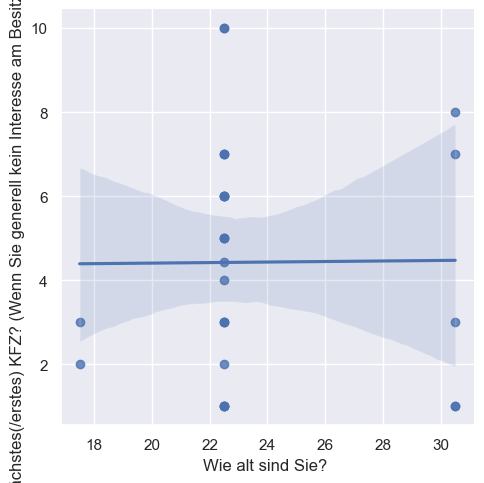

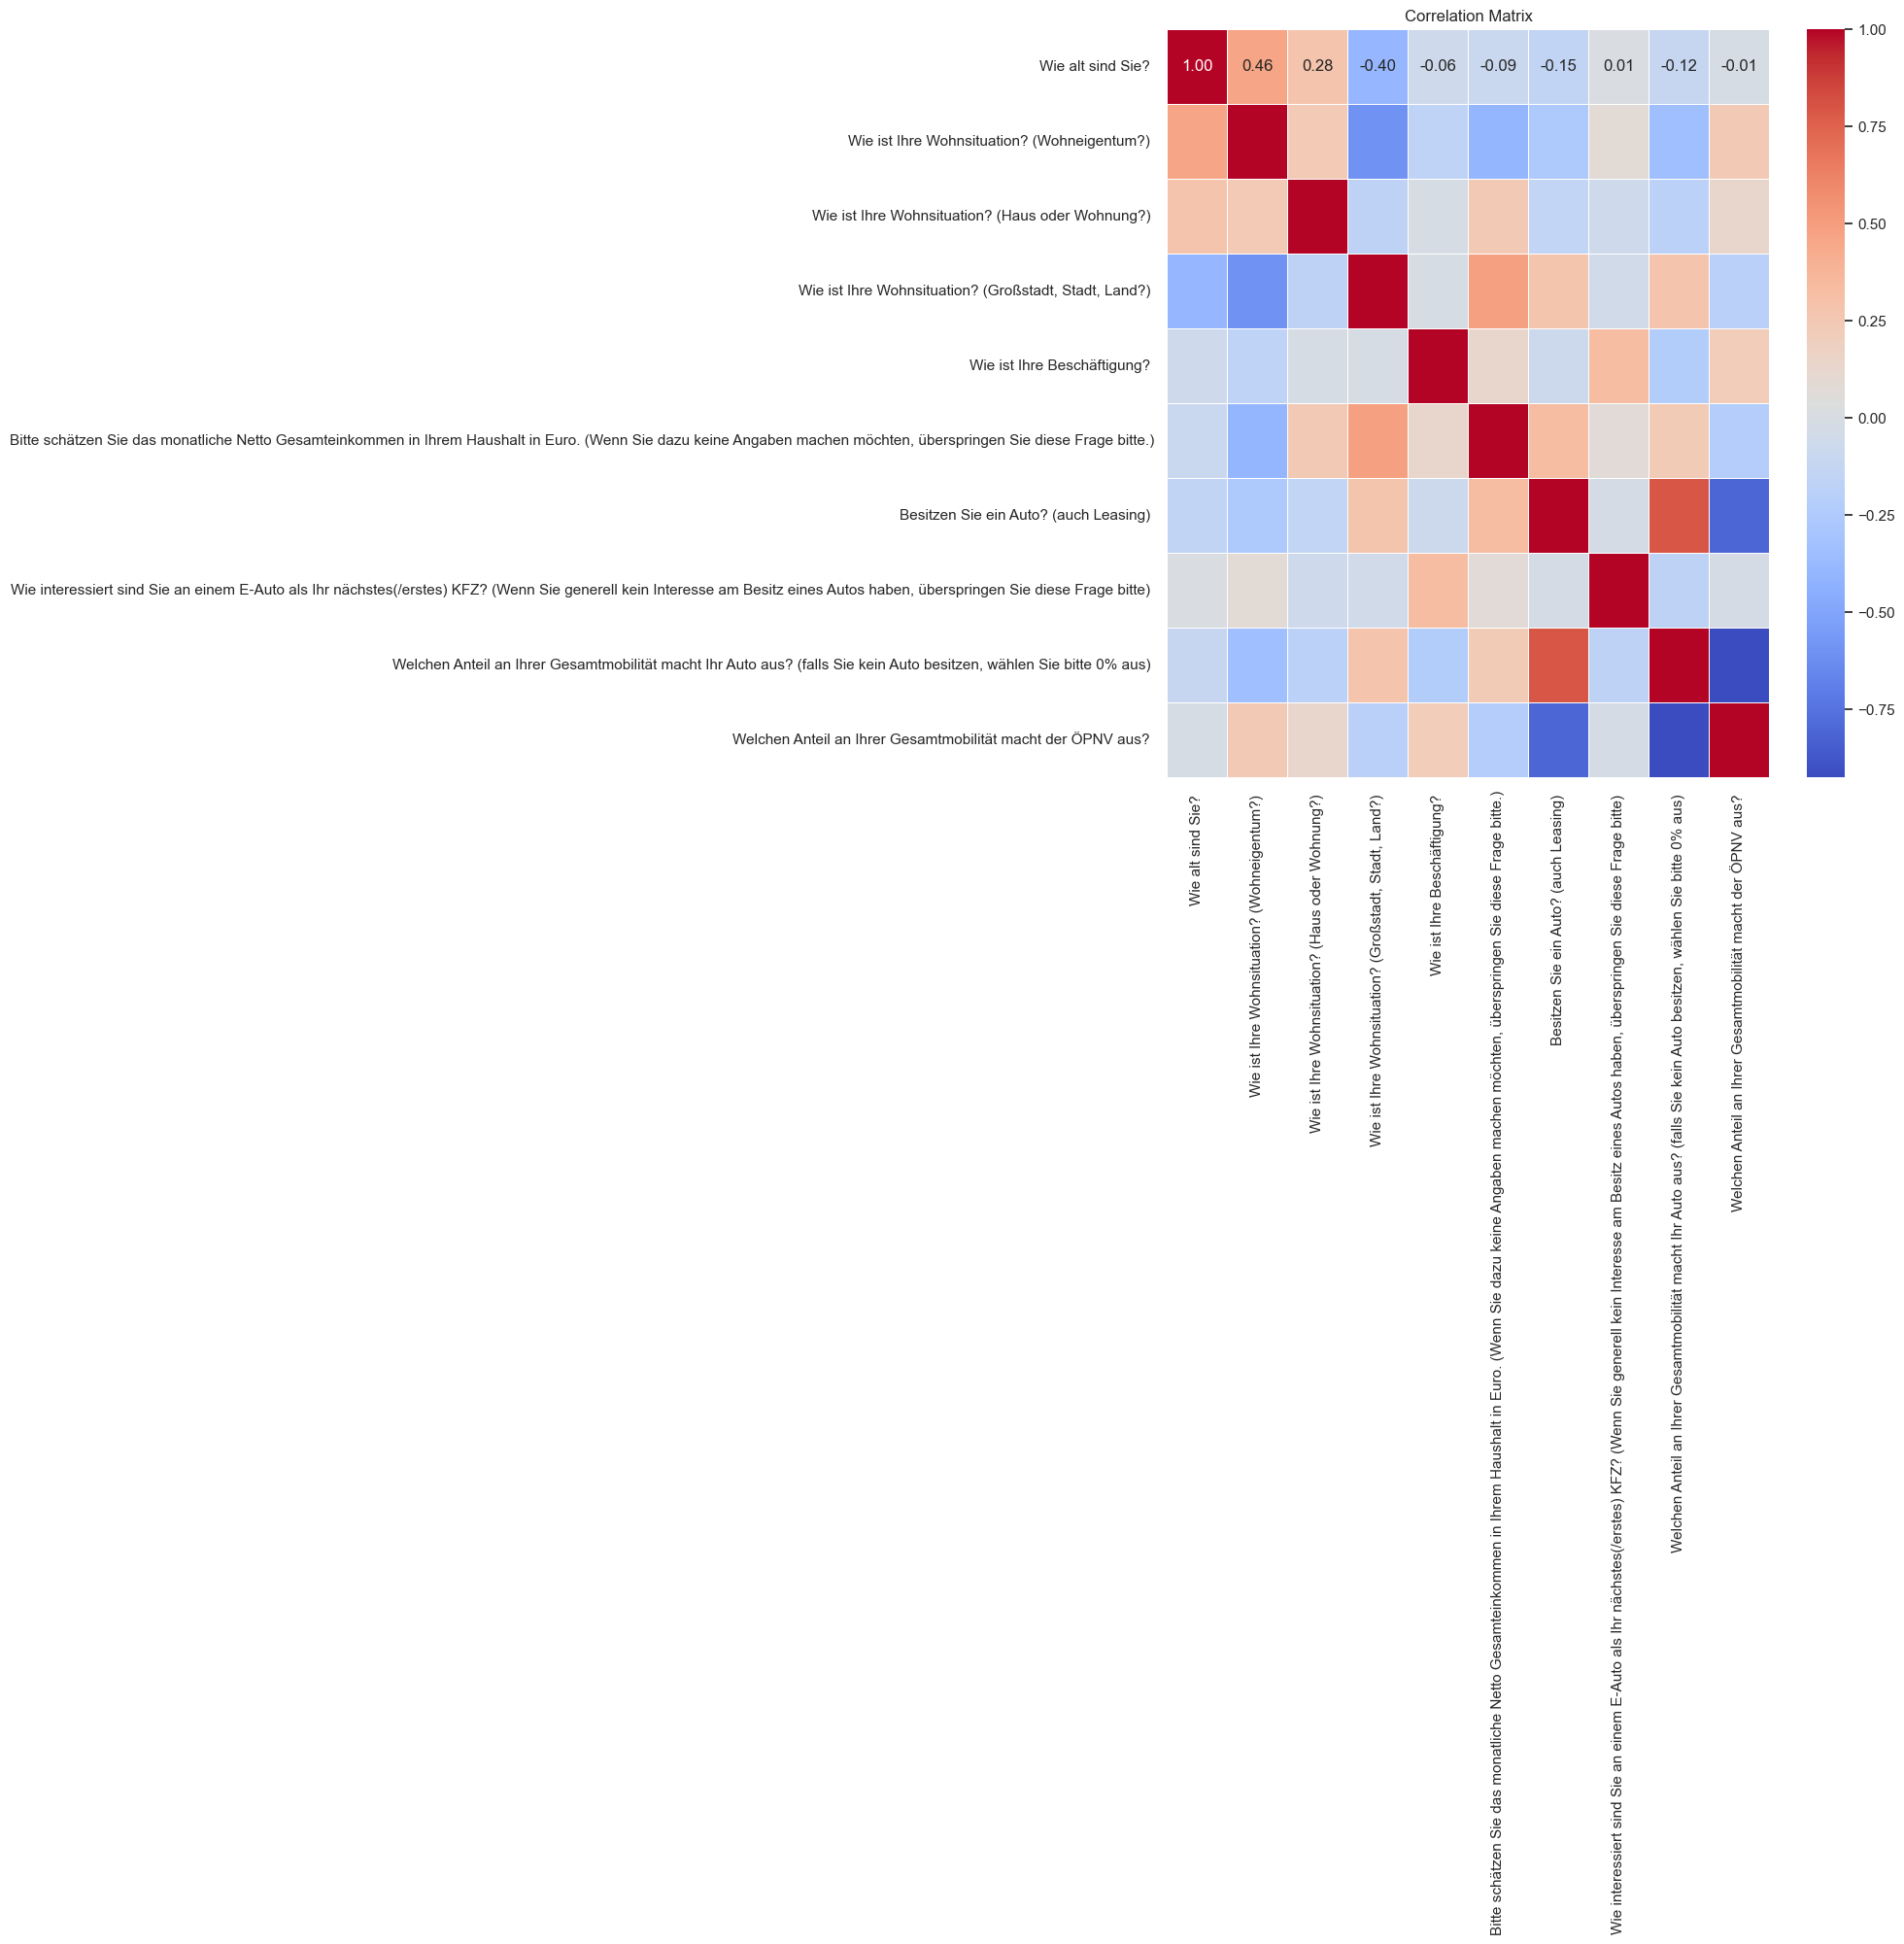

In [242]:
# Visualizing the data
visualize_data(data_copy)
# Visualizing the correlation between the features and the target
visualize_correlation(data_copy, financial_feature_columns, target_column)
#TODO: Implement the same for the other use cases

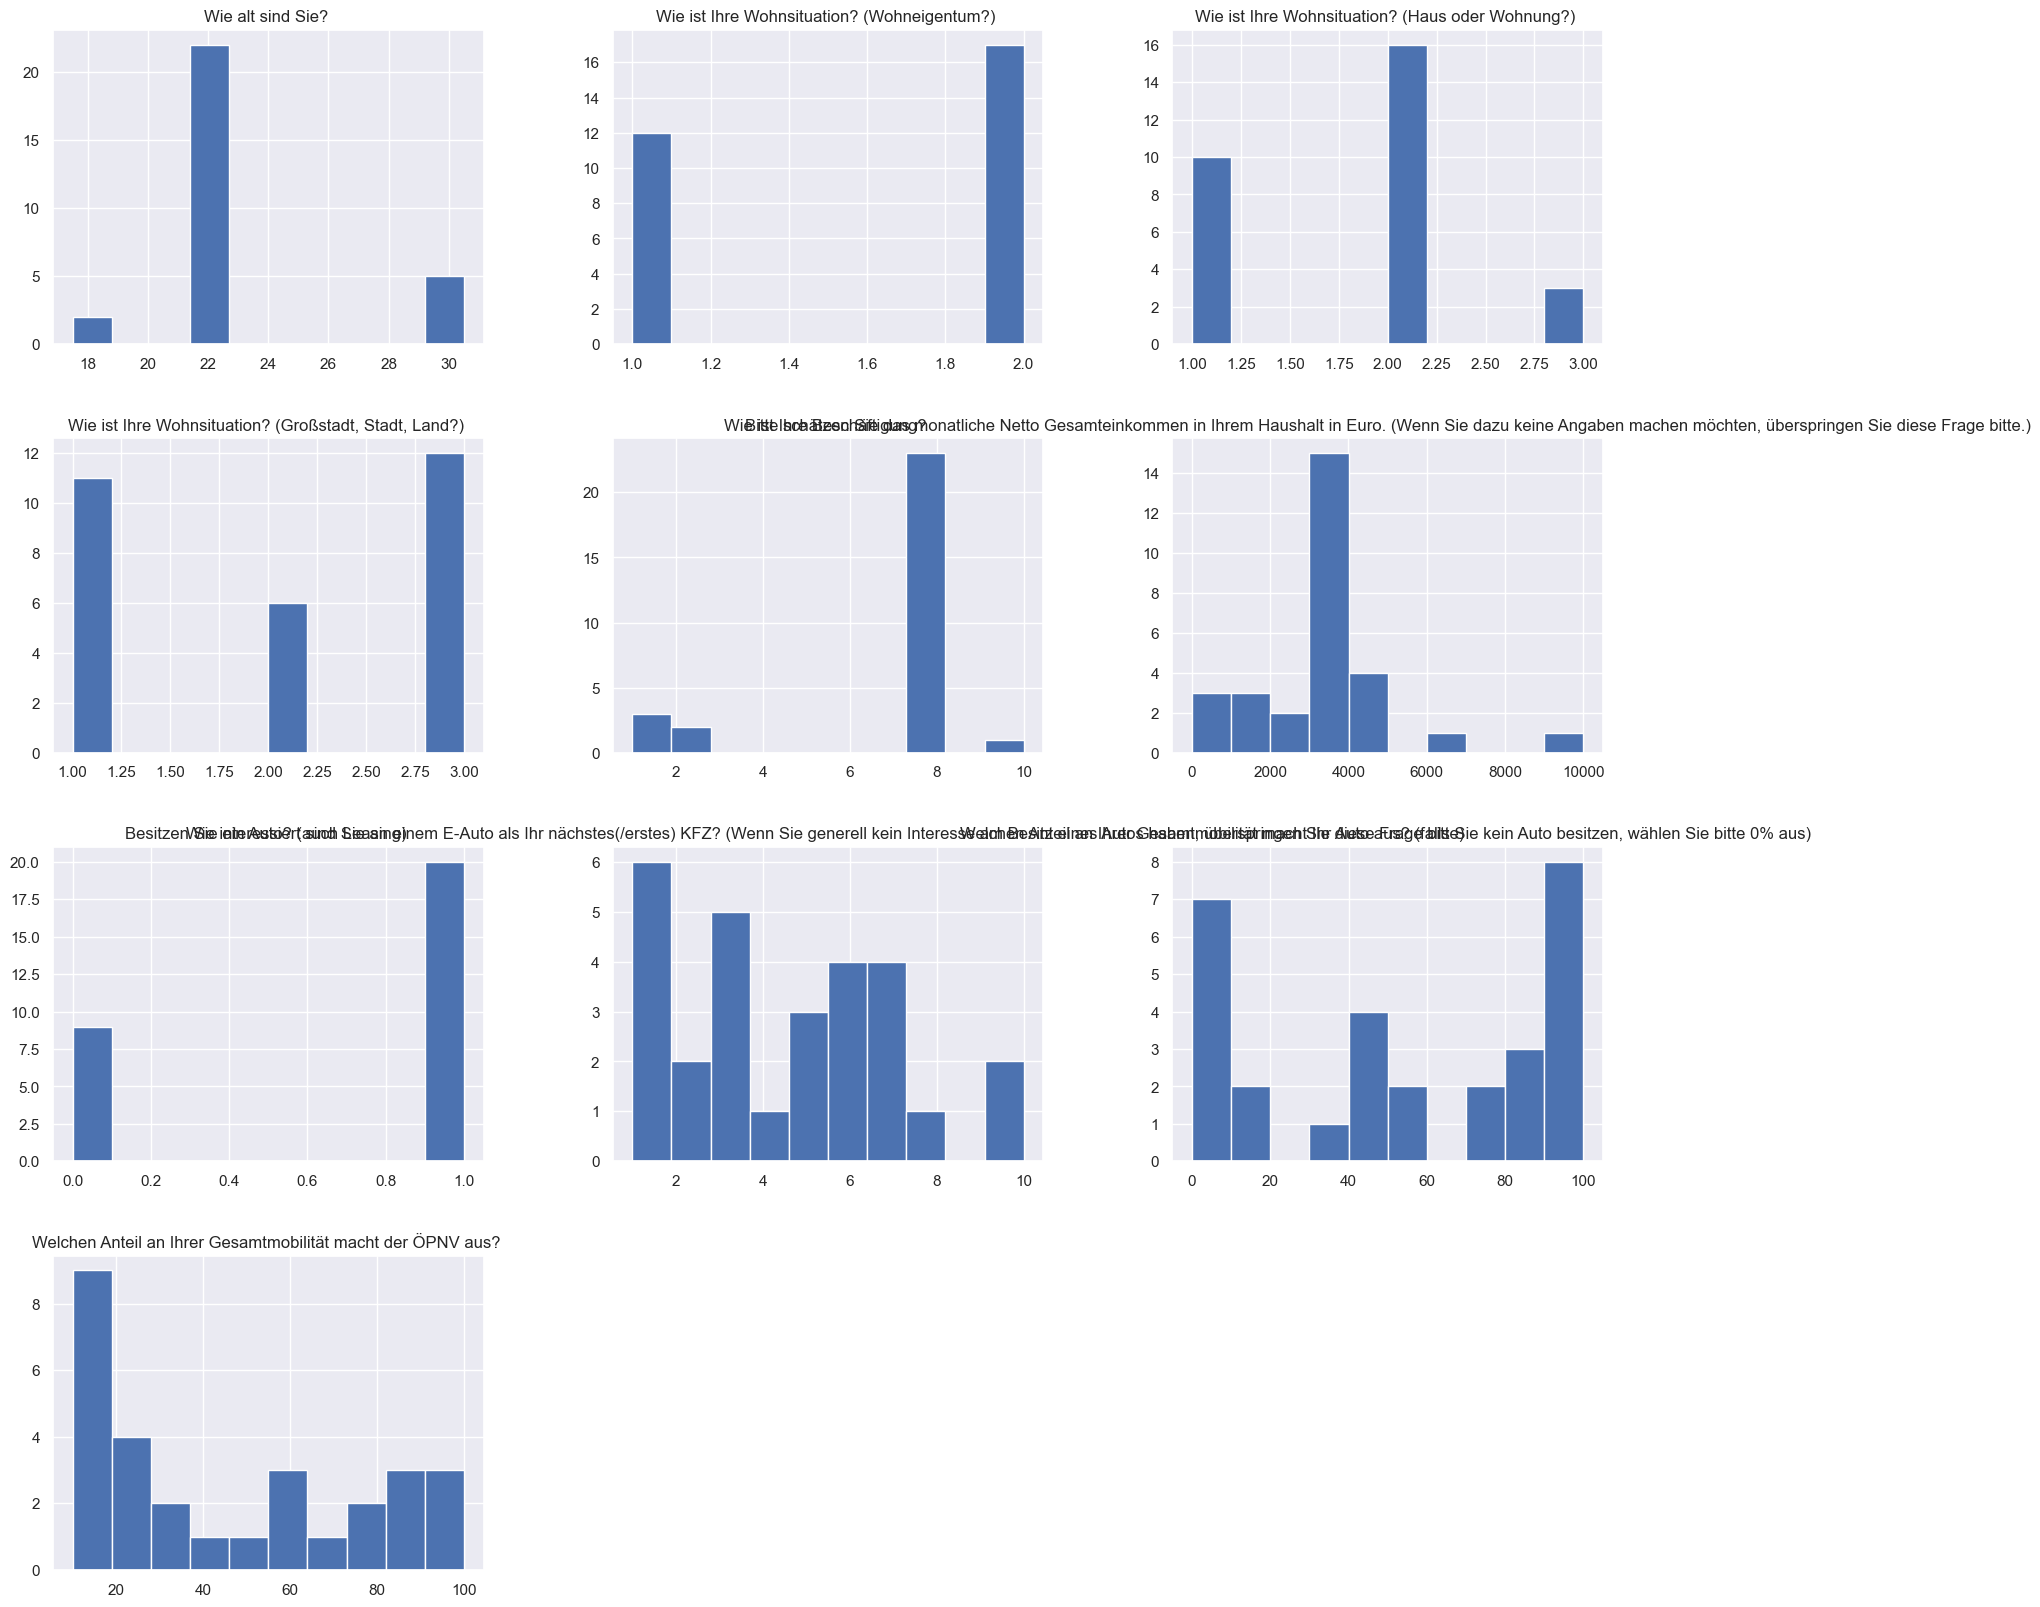

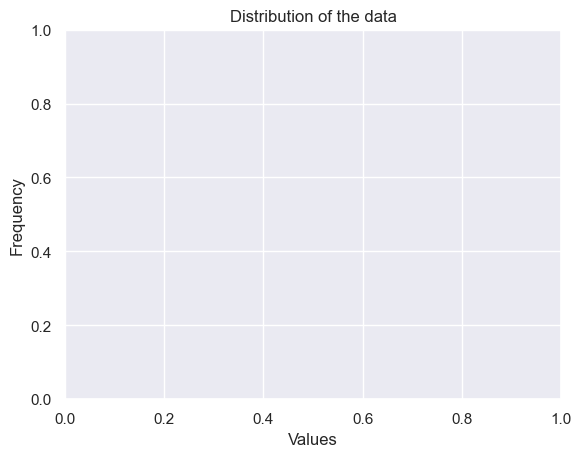

In [218]:
# Plotting the distribution of the data
df_uni_data.hist(figsize=(20, 20))
plt.show()
# add seaborn style
sns.set()
# add title and labels
plt.title('Distribution of the data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

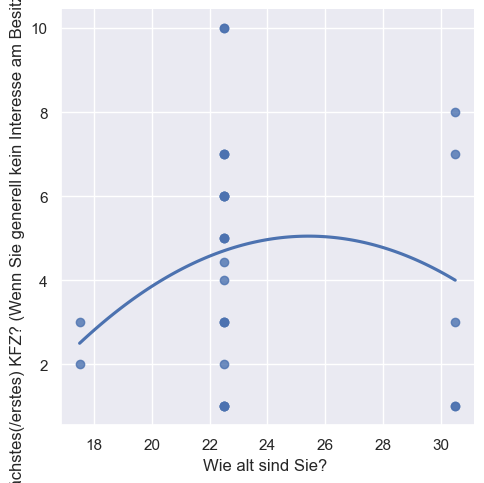

-1.2139245943190091


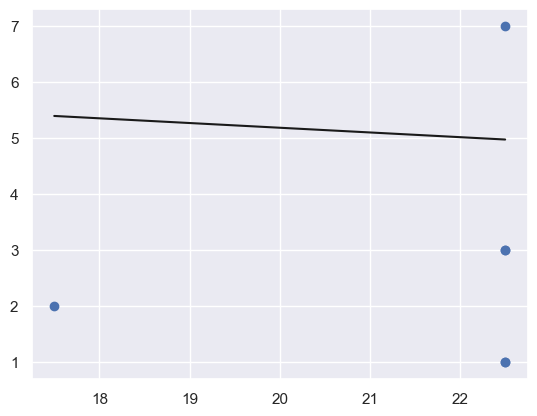

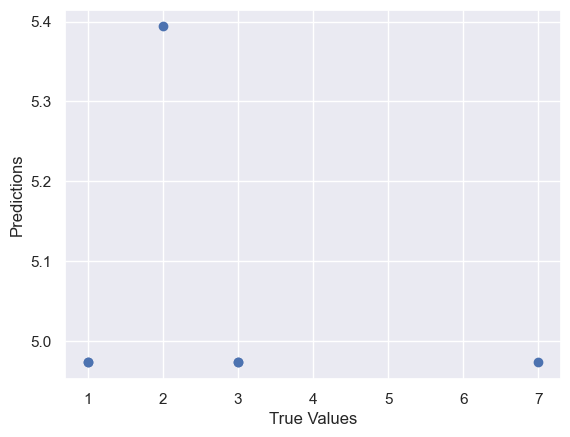

In [219]:
# linear regression analysis age vs interest in e-car
linear_regression_analysis(data_copy, age, interest_e_car)

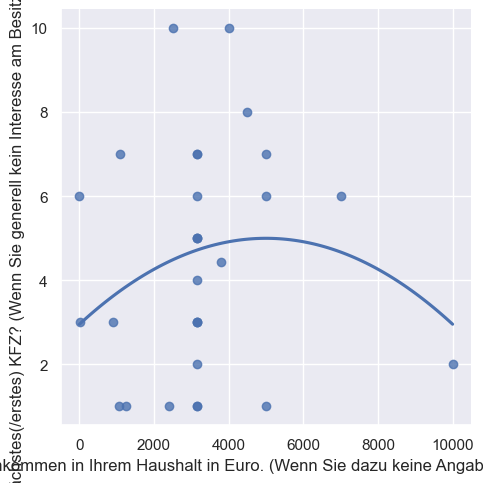

-0.30018995619877464


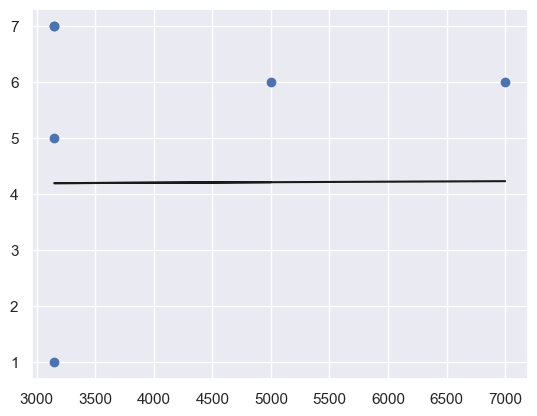

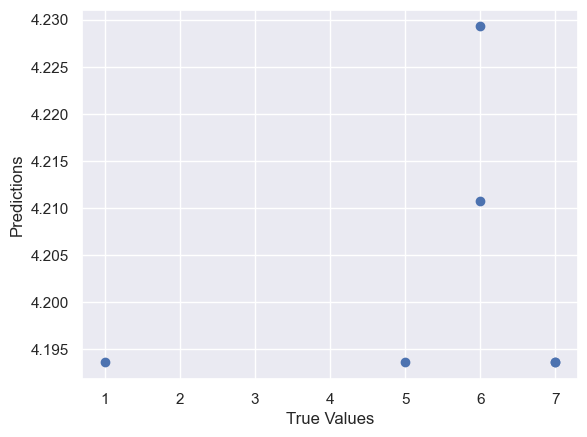

In [220]:
# linear regression analysis monthly income vs interest in e-car
linear_regression_analysis(data_copy, monthly_income, interest_e_car)

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


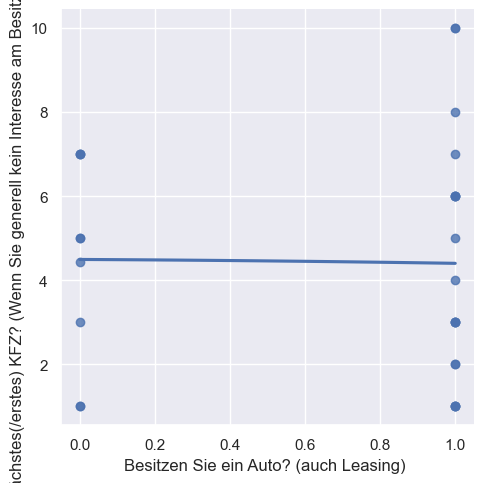

-0.05400190257189408


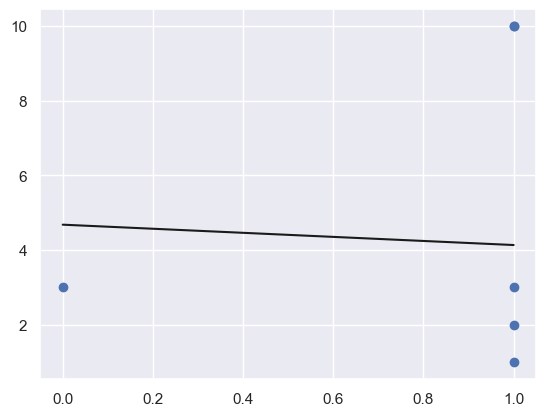

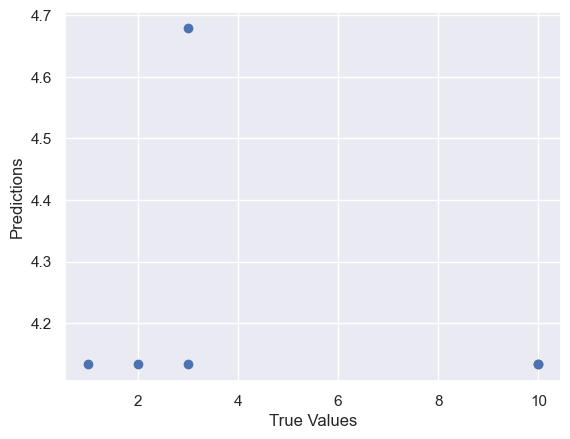

In [221]:
# linear regression analysis car ownership vs interest in e-car
linear_regression_analysis(data_copy, car_ownership, interest_e_car)

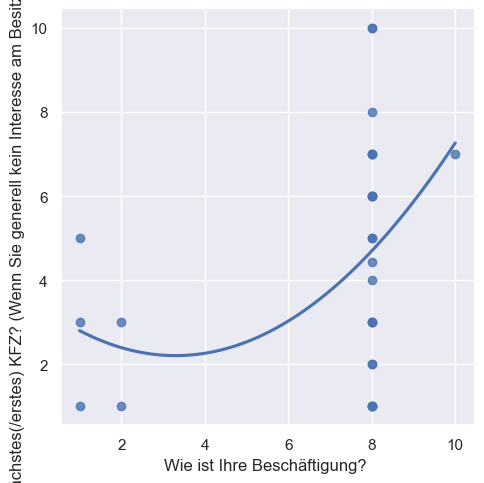

0.0959250595822091


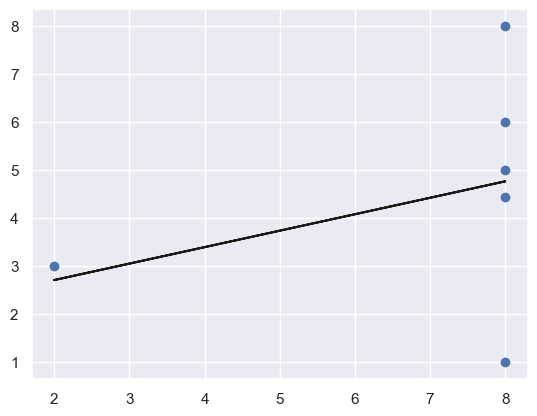

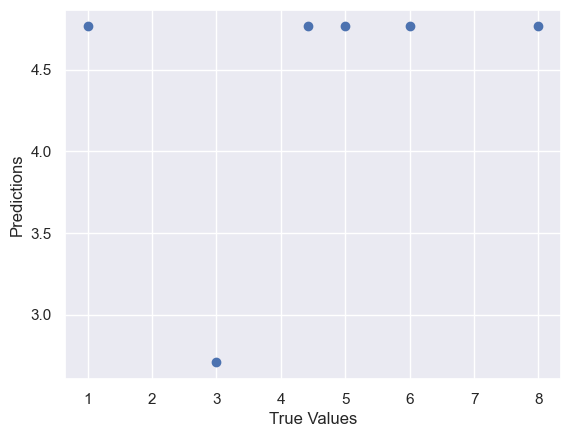

In [222]:
linear_regression_analysis(data_copy, employment, interest_e_car)

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


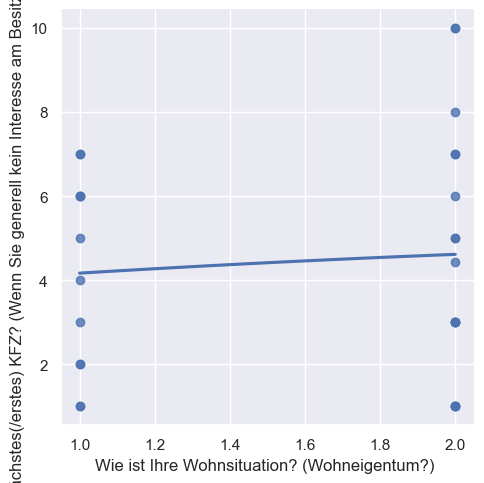

-0.86398397294818


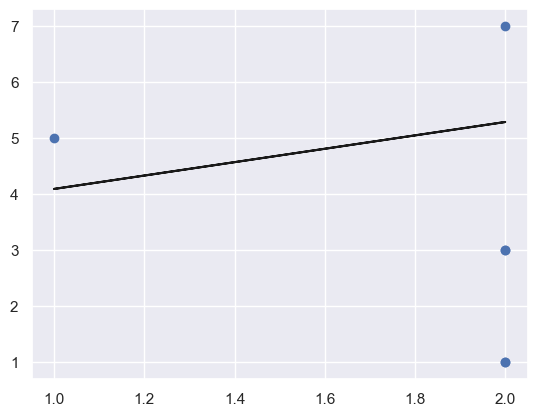

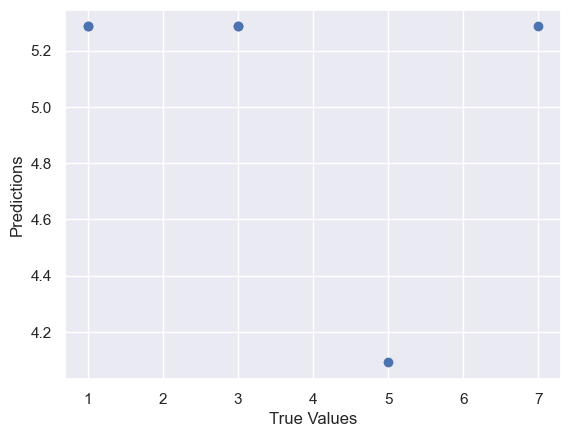

In [223]:
linear_regression_analysis(data_copy, living_situation, interest_e_car)

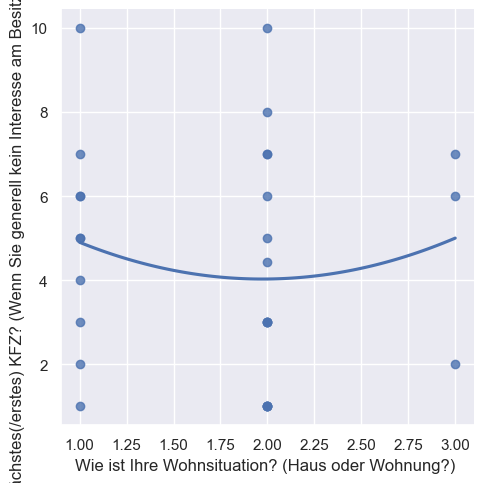

-0.590896270588207


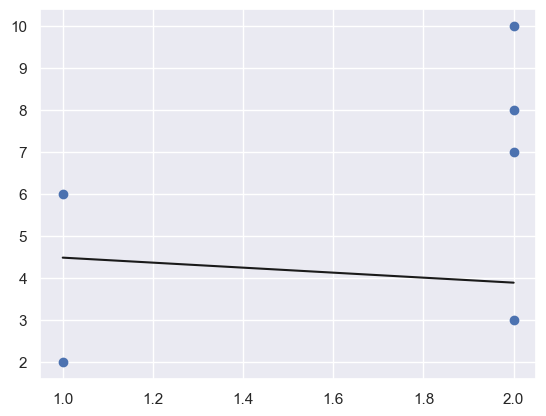

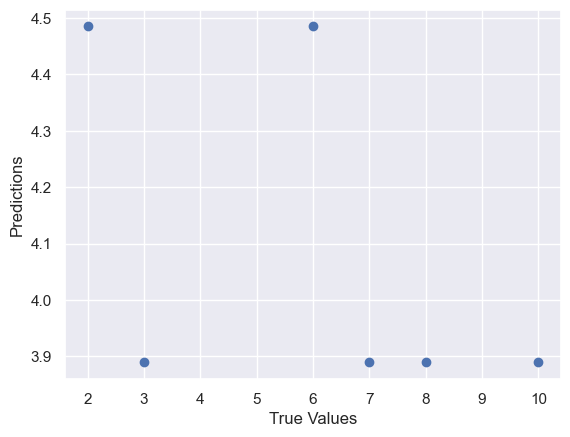

In [224]:
linear_regression_analysis(data_copy, living_situation_house_apartment, interest_e_car)

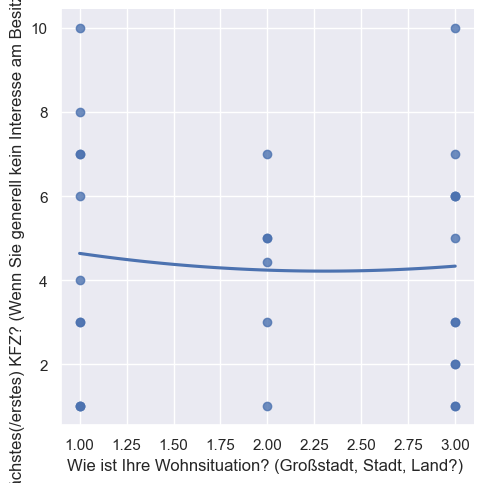

-0.3714357453543313


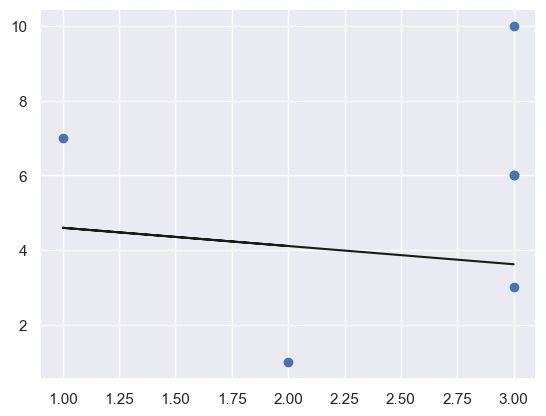

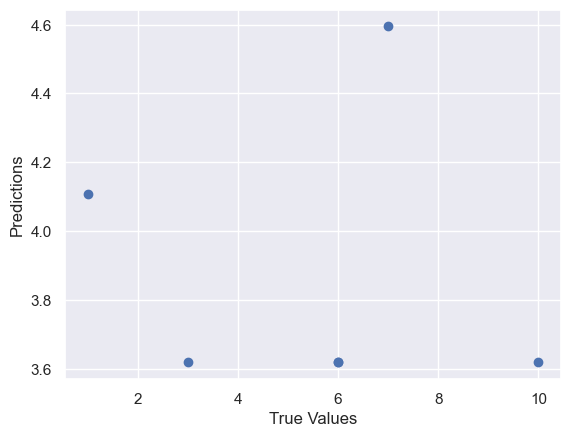

In [225]:
linear_regression_analysis(data_copy, living_situation_city, interest_e_car)

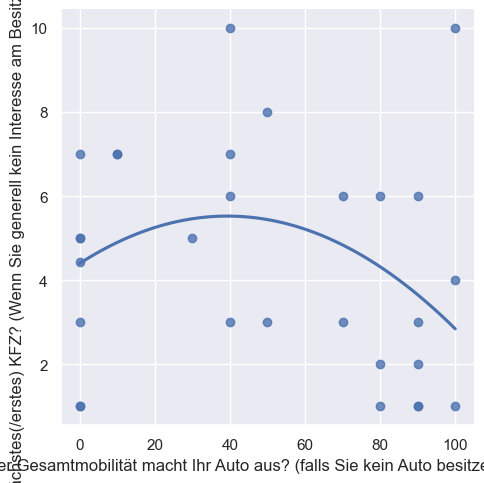

0.05192123245362923


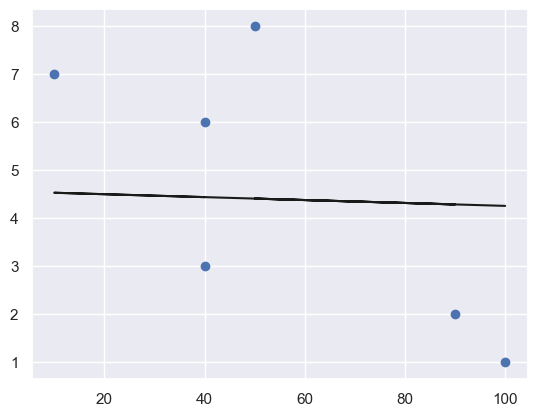

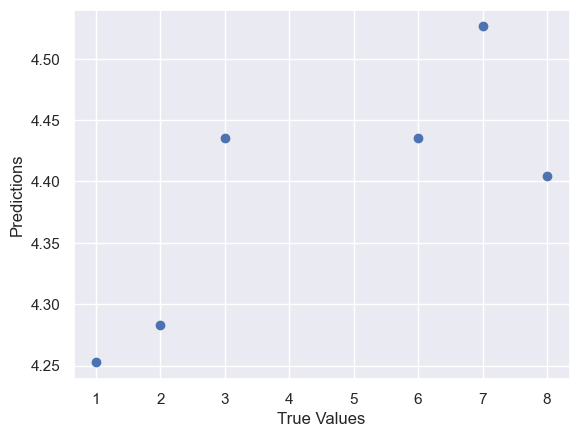

In [226]:
# mobility_car vs interest_e_car
linear_regression_analysis(data_copy, mobility_car, interest_e_car)

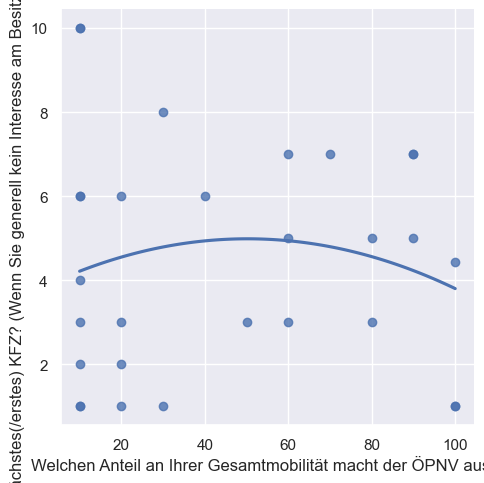

-0.10260866763682874


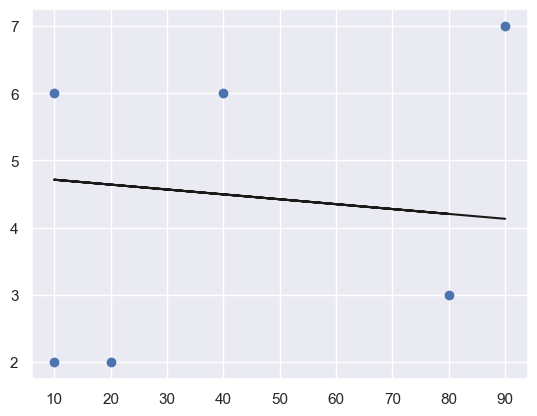

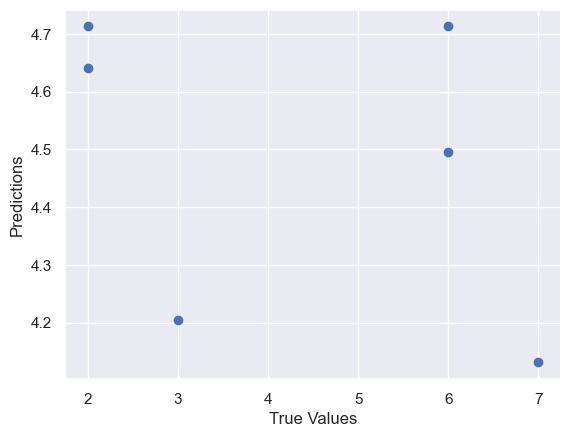

In [227]:
# mobility_public_transport vs interest_e_car
linear_regression_analysis(data_copy, mobility_public_transport, interest_e_car)

0.06079841320364243


ValueError: x and y must be the same size

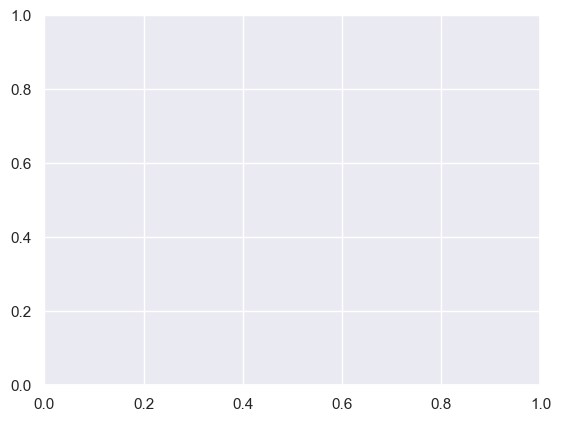

In [228]:
# age, employment vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, employment], interest_e_car)

-0.05339751514684021


ValueError: x and y must be the same size

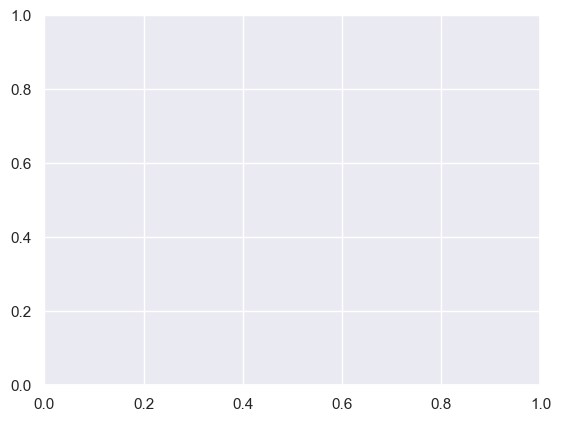

In [229]:
# age, income vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, monthly_income], interest_e_car)

-0.004729455785958514


ValueError: x and y must be the same size

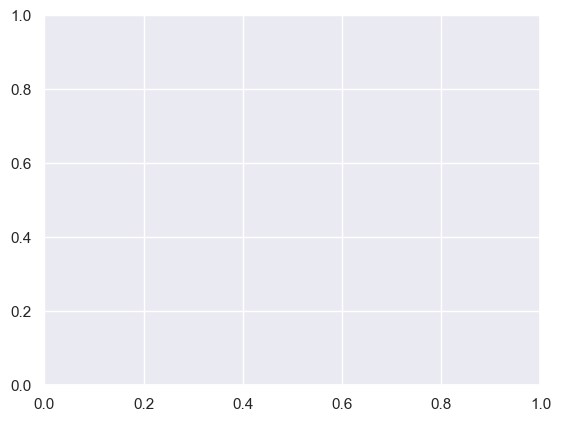

In [230]:
# age, car ownership vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, car_ownership], interest_e_car)

-0.22379241184162457


ValueError: x and y must be the same size

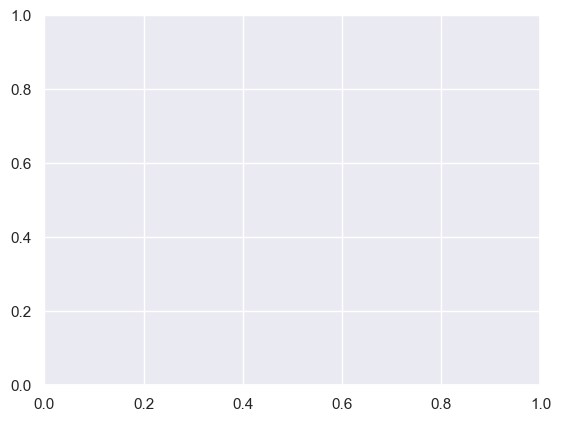

In [231]:
# age, living situation vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, living_situation], interest_e_car)

-0.5528203572281278


ValueError: x and y must be the same size

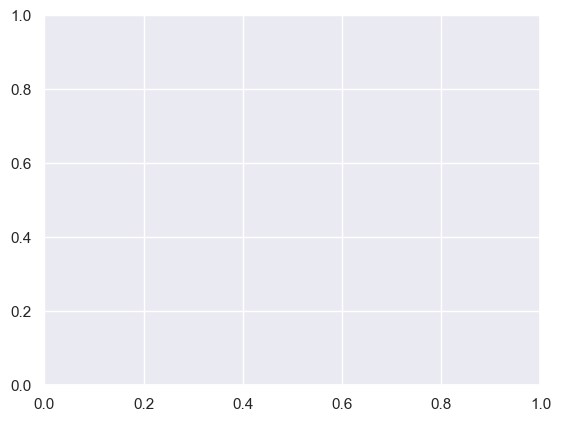

In [232]:
# age, living situation house apartment vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, living_situation_house_apartment], interest_e_car)

-1.3676726244779864


ValueError: x and y must be the same size

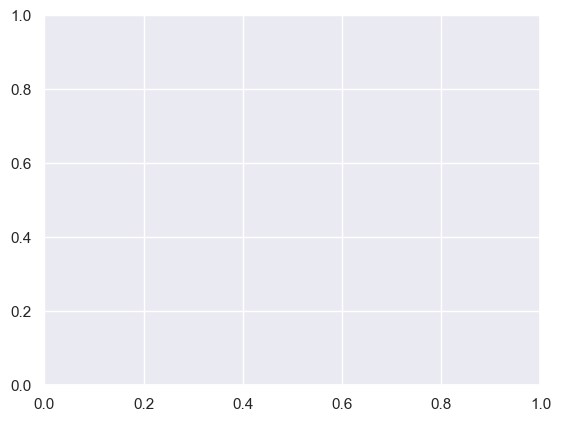

In [233]:
# age, living situation city vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, living_situation_city], interest_e_car)